In [21]:
import scipy.stats
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr
import tqdm
import os
import pickle
from tqdm.notebook import tqdm


## set plotting style
sns.set()

# ## initialize random number generator
# rng = np.random.default_rng()

path = "/glade/work/alancelin/EVT_rossbypalooza/"
os.chdir(path)

from src.evt import *

## Compute training and validation data

In [ ]:
from pydrive.auth import GoogleAuth, ServiceAccountCredentials
from pydrive.drive import GoogleDrive

# Step 1: Load client secrets
gauth = GoogleAuth()
gauth.LoadClientConfigFile('/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/client_secret.json')  # Use your downloaded JSON file

# Step 2: Handle manual authentication
gauth.CommandLineAuth()  # Opens a URL in the terminal for manual authentication

# Step 3: Create GoogleDrive instance
drive = GoogleDrive(gauth)
drive

In [ ]:
# Step 4: Define the folder ID
folder_id = '1zXUQmBBQWTJ796bgdi_ZgbV3Lnwfn2tk'

# Step 5: List the files in the specified folder
folder_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()
folder_list_names = [file['title'] for file in folder_list]
# for file in folder_list:
#     print(f'title: {file["title"]}, id: {file["id"]}')

# for each folder 'sim0', print the files
for file in folder_list:
    if file['title'] == 'sim0':
        sim0_id = file['id']
        sim0_file_list = drive.ListFile({'q': f"'{sim0_id}' in parents and trashed=false"}).GetList()
        # for sim0_file in sim0_file_list:
        #     print(f'title: {sim0_file["title"]}, id: {sim0_file["id"]}')

# in that folder 'sim0', read the file 'tas_lat.46_lon.6_spatial.2_reduce.min.csv' using pandas
for file in sim0_file_list:
    if file['title'] == 'tas_lat.46_lon.6_spatial.2_reduce.mean.csv':
        file.GetContentFile('tas_lat.46_lon.6_spatial.2_reduce.mean.csv')
        df_train_val = pd.read_csv('tas_lat.46_lon.6_spatial.2_reduce.mean.csv', index_col=0)

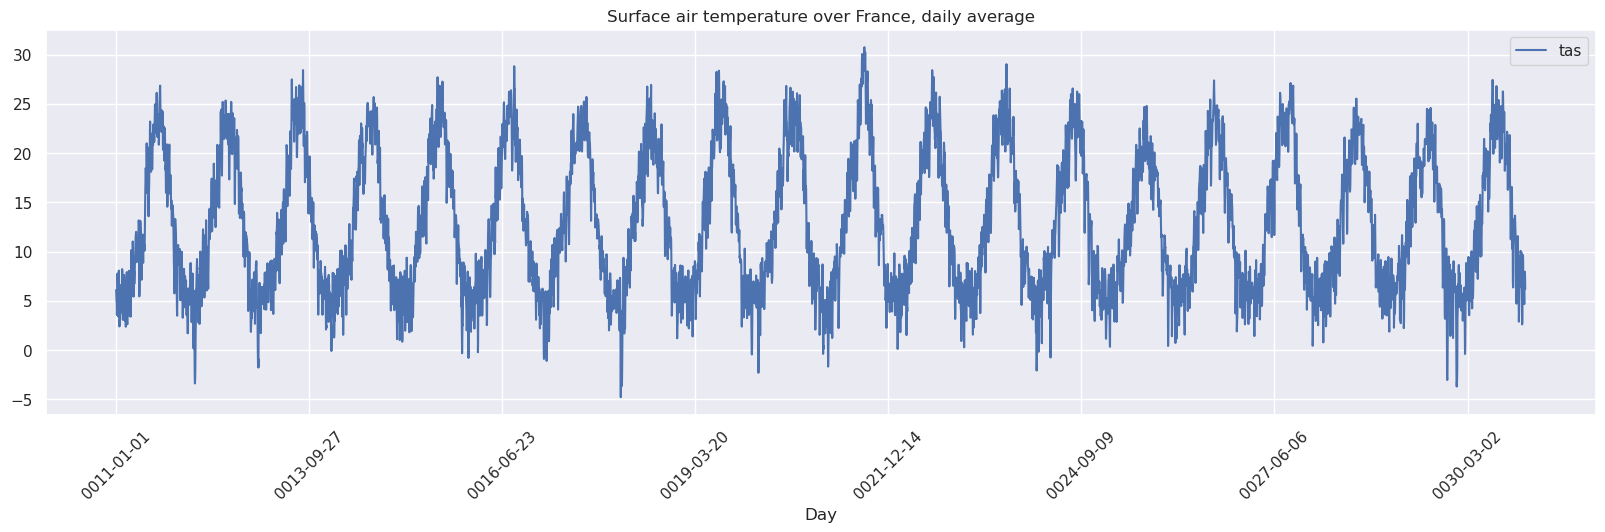

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
# print time series of df for the first 10 years
(df_train_val - 273.15).iloc[:20*365].plot(ax=ax)
# change orientation of x-axis labels
plt.xticks(rotation=45)
# add title
plt.title('Surface air temperature over France, daily average')
plt.show()

In [ ]:
def preprocess(df, T=7):
    # convert the index to pandas.period
    df.index = pd.PeriodIndex(df.index, freq='D')
    # convert the temperature to celsius
    df = df - 273.15
    # compute the T-day rolling mean
    df = df.rolling(T).mean()
    # take the minimum of each year (Block Maxima approach)
    df = df.groupby(df.index.year).min()
    # change day to year
    df.index.name = 'Year'
    return df

In [ ]:
T=7
A_train_val = preprocess(df_train_val, T=T)
# save the preprocessed data
A_train_val.to_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_train_val_T{T}.csv')

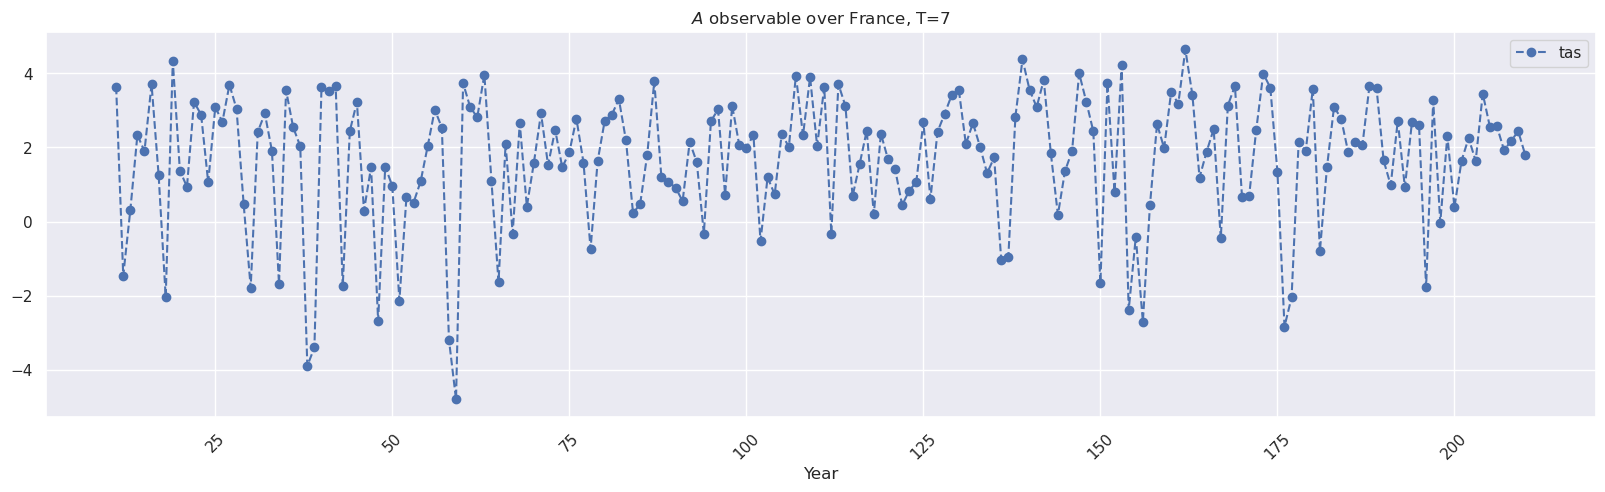

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
# print time series of df for the first 10 years (scatter plot)
(A_train_val).iloc[:200].plot(ax=ax, marker='o', linestyle='--')
# change orientation of x-axis labels
plt.xticks(rotation=45)
# add title
plt.title(r'$A$'+ f' observable over France, T={T}')
plt.show()

## Compute test data (long ground truth)

In [ ]:
# for every folder in folder_list, read the file 'tas_lat.46_lon.6_spatial.2_reduce.min.csv' using pandas and finally concatenate all the dataframes
dfs = []

def produce_A_ground_truth(folder_list, T=7):
    for file in tqdm(folder_list):
        sim0_id = file['id']
        if file['title'] == 'sim0':
            # skip the folder 'sim0'
            continue
        sim0_file_list = drive.ListFile({'q': f"'{sim0_id}' in parents and trashed=false"}).GetList()
        for sim0_file in sim0_file_list:
            if sim0_file['title'] == 'tas_lat.46_lon.6_spatial.2_reduce.mean.csv':
                sim0_file.GetContentFile('tas_lat.46_lon.6_spatial.2_reduce.mean.csv')
                dfs.append(preprocess(pd.read_csv('tas_lat.46_lon.6_spatial.2_reduce.mean.csv', index_col=0), T=T))
    return pd.concat(dfs, axis=0, ignore_index=True)

A_test = produce_A_ground_truth(folder_list, T=14)
# A_test.to_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{T}.csv')

100%|██████████| 44/44 [03:56<00:00,  5.37s/it]


In [ ]:
len(A_test)

In [ ]:
A_test = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{T}.csv', index_col=0)

## First Plot: Return time curve with 80 years of training data (using MC sampling)

In [68]:
# PARAMS 
n_train = 80
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0.001, 10]) # SELECT YOUR BOUNDS

# SELECT YOUR DATA INSTEAD 
# Load data 
T = 7
A_test = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{T}.csv', index_col=0)
A_train_val = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_train_val_T{T}.csv', index_col=0)

X_train = - A_train_val.values.squeeze()
X_test = - A_test.values.squeeze()
X_train, len(X_test)

(array([-3.63789857,  1.45970286, -0.30284714, ..., -2.50665857,
        -0.70897143, -3.13726571]),
 53321)

In [69]:
## Empirical return period
tr_empirical, Xr_empirical = get_empirical_return_period(X_train)

## Fit model and get return levels
model_type = "gev"
if model_type == "gev":
    model_class = scipy.stats.genextreme
    thresh = None
model = fit_model(X_train, model_class, bounds)
Xr, tr = get_return_levels(model)

## Compute confidence interval
n_mc = 100

Xr_mean, Xr_median, Xr_lb, Xr_ub = compute_MC_return_period_bnds(
    X_test, model_class=model_class, bounds=bounds, n_train=n_train, n_mc=n_mc)
# Compute the same with Gaussian fit 
Xr_mean_gauss, Xr_median_gauss, Xr_lb_gauss, Xr_ub_gauss = compute_MC_return_period_bnds(
    X_test, model_class=scipy.stats.norm, bounds=bounds, n_train=n_train, n_mc=n_mc)

 17%|█▋        | 17/100 [00:04<00:17,  4.87it/s]/glade/u/apps/opt/conda/envs/npl/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3071: RuntimeWarning: overflow encountered in exp
  pex2 = np.exp(logpex2)
  0%|          | 0/100 [00:00<?, ?it/s]/glade/work/alancelin/EVT_rossbypalooza/src/evt.py:20: RuntimeWarning: Bounds provided for the following unrecognized parameters will be ignored: {'c'}
  params = scipy.stats.fit(dist=model_class, data=data, bounds=bounds).params
100%|██████████| 100/100 [00:02<00:00, 35.06it/s]


/glade/derecho/scratch/alancelin/tmp/ipykernel_83378/3470880355.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{-y if y !=0 else 0}" for y in ax.get_yticks()])


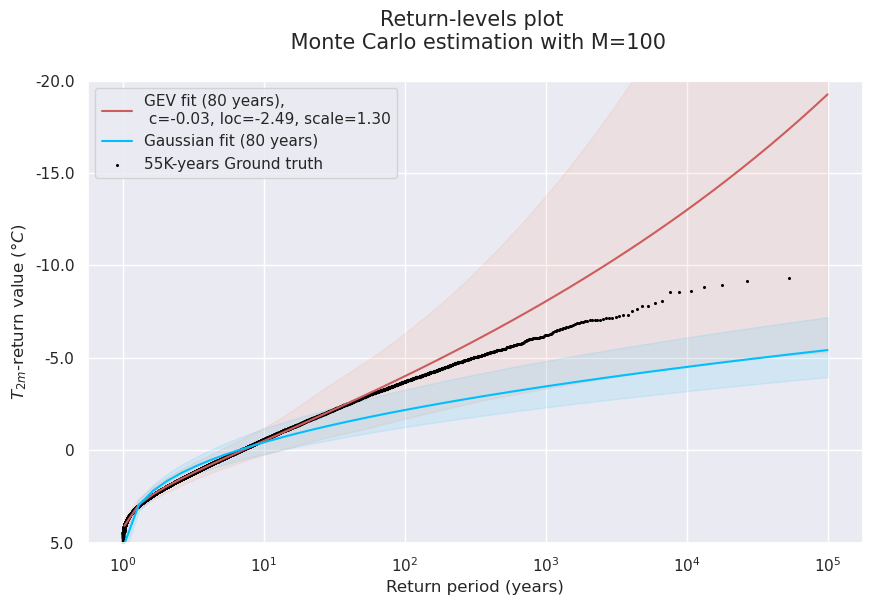

In [70]:
import seaborn as sns
sns.set()
fig, ax = plt.subplots(figsize=(10, 6))

## plot modeled return period
ax.plot(tr, Xr_mean, c="indianred", label=f"GEV fit ({n_train} years), \n c={model.args[0]:.2f}, loc={model.args[1]:.2f}, scale={model.args[2]:.2f}")
ax.fill_between(tr, Xr_ub, Xr_lb, color="coral", alpha=0.1)


## plot modeled return period
ax.plot(tr, Xr_mean_gauss, c="deepskyblue", label=f"Gaussian fit ({n_train} years)")
ax.fill_between(tr, Xr_ub_gauss, Xr_lb_gauss, alpha=0.1, color="deepskyblue")

## label axes
ax.set_xlabel("Return period (years)")
ax.set_ylabel(r"$T_{2m}$-return value ($°C$)") # MY DATA IS IN CELSIUS, but you can change it to whatever you want
ax.set_xscale("log")
ax.set_ylim(-5, 20)

# add the gound truth
t_test_r_empirical, X_test_r_empirical = get_empirical_return_period(X_test)
ax.scatter(t_test_r_empirical, X_test_r_empirical, c='black', s=1.5, label='55K-years Ground truth')


# # # compute negative log likelihood on the test set
# NLL_test = -model.logpdf(X_test).sum()/len(X_test)
# # print it in the plot in the bottom right corner
# ax.text(0.7, 0.2, f'test NLL={NLL_test:.2f}', transform=ax.transAxes)

plt.title(f"Return-levels plot \n Monte Carlo estimation with M={n_mc}", y = 1.05, fontsize=15)
plt.legend()
# put a minus in the y-axis values but keep the same direction
ax.set_yticklabels([f"{-y if y !=0 else 0}" for y in ax.get_yticks()])
plt.show()

## Second plot: Boxplots of biais v.s number of training data

In [27]:
import importlib
import src.evt
importlib.reload(src.evt)
from src.evt import get_target_return_value, compute_MC_return_value
get_target_return_value(X_test, 1000)

(6.215210714285693, 53268)

In [28]:
n_train_list = [40, 80, 160, 320, 640, 1280, 5000, 10000]
n_mc = 20

target_return_period = 1000 # We should probably stick to 1000 years to compare our plots (but feel free to try other values for your own curiosity)
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0.001, 10])

target_return_value = get_target_return_value(X_test, target_return_period)[0]

Xr_samples_list = []
Xr_samples_list_gauss = []



for n_train in tqdm(n_train_list):
    Xr_samples = compute_MC_return_value(X_test, model_class, bounds, n_train=n_train, n_mc=n_mc, return_periods=target_return_period)
    Xr_samples_list.append(Xr_samples)
    Xr_samples_gauss = compute_MC_return_value(X_test, scipy.stats.norm , bounds=None, n_train=n_train, n_mc=n_mc, return_periods=target_return_period)
    Xr_samples_list_gauss.append(Xr_samples_gauss)
    
Xr_samples_list = np.stack(Xr_samples_list, axis=0)
Xr_samples_list_gauss = np.stack(Xr_samples_list_gauss, axis=0)

100%|██████████| 8/8 [00:54<00:00,  6.84s/it]


/glade/derecho/scratch/alancelin/tmp/ipykernel_83378/1850661939.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{-y if y !=0 else 0}" for y in ax.get_yticks()])


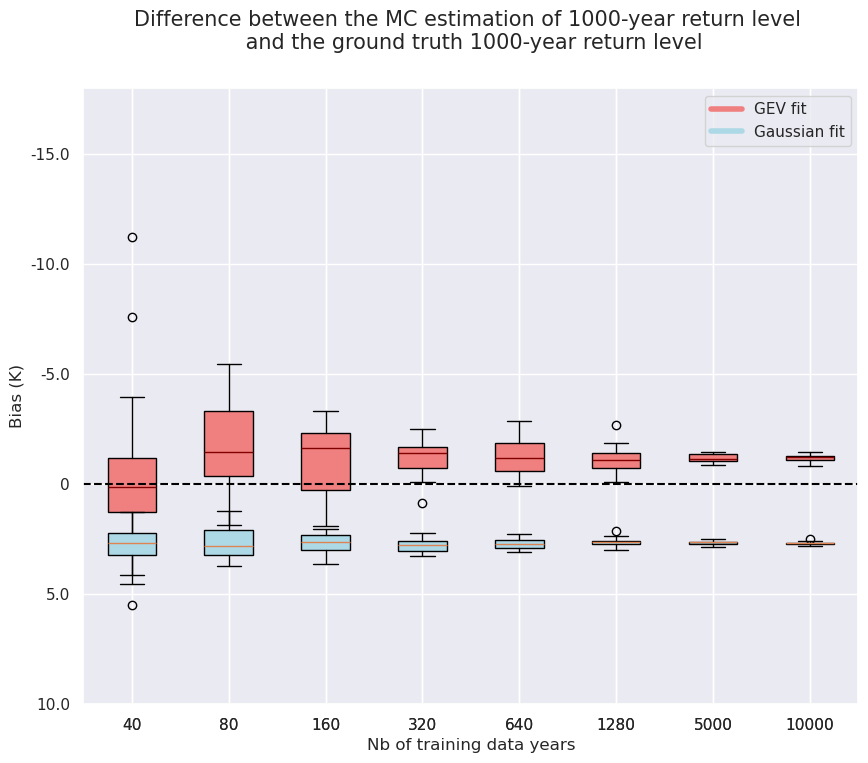

In [47]:
import seaborn as sns
sns.set()
# Create the box plot
fig, ax = plt.subplots(figsize=(10, 8))

bias = (-target_return_value + Xr_samples_list).T
# change color of median 
plt.boxplot(bias, vert=True, patch_artist=True, labels=n_train_list, boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="maroon")) #, label= 'Gaussian fit')

bias_gauss = (-target_return_value + Xr_samples_list_gauss).T
# change color for the gaussian model
plt.boxplot(bias_gauss, vert=True, patch_artist=True, labels=n_train_list, boxprops=dict(facecolor="lightblue")) #, label= 'Gaussian fit')

# Create custom handles for the legend
handles = [
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='GEV fit'),
    plt.Line2D([0], [0], color='lightblue', lw=4, label='Gaussian fit')
]


# Add the legend
plt.legend(handles=handles, loc='upper right')

# Add title and labels
plt.title('Box plot of n_values')
plt.xlabel('Nb of training data years')
plt.ylabel(f'Bias (K)')
plt.title(f'Difference between the MC estimation of {target_return_period}-year return level \n and the ground truth {target_return_period}-year return level', y = 1.05, fontsize=15)
# plot a straight line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-10, 18)

# Show the plot
# put a minus in the y-axis values but keep the same direction
ax.set_yticklabels([f"{-y if y !=0 else 0}" for y in ax.get_yticks()])
plt.show()

In [48]:
np.median(bias, axis=0), np.median(bias_gauss, axis=0)

(array([-0.11806543,  1.46106559,  1.64521102,  1.42588851,  1.18965417,
         1.12207131,  1.14773595,  1.24751221]),
 array([-2.67720082, -2.78801382, -2.62645598, -2.77485753, -2.70603703,
        -2.64190936, -2.6452735 , -2.67702481]))

### Add electricity demand

France has several nuclear power plants, and their capacity typically ranges from about 900 MW to 1,450 MW per reactor.
- For example, the Gravelines Nuclear Power Plant has a total capacity of about 5,460 MW (six reactors of 910 MW each).
- If we consider a plant with a capacity of 1,000 MW operating at full capacity for one year, the energy produced would be  $1,000 \text{ MW} \times 24 \text{ hours/day} \times 365 \text{ days/year} \times 10^{-3} \text{ GWh/MW} = 8,760 \text{ GWh/year}$ .

To calculate the energy production of a power plant with a capacity of 1,000 MW operating at full capacity for one week, you can use the following formula:
$$ \text{Energy (GWh)} = \text{Power (MW)} \times \text{Time (hours)} \times 10^{-3} $$
First, calculate the number of hours in one week:
$$ \text{ week} = 7 \text{ days} \times 24 \text{ hours/day} = 168 \text{ hours} $$
Now, use the formula to calculate the energy production:
$$ \text{Energy (GWh)} = 1,000 \text{ MW} \times 168 \text{ hours} \times 10^{-3} = 168 \text{ GWh} $$
So, a power plant with a capacity of 1,000 MW would produce 168 GWh of energy in one week if it operates at full capacity.

In [55]:
def convert_to_Nuclear_power_plant_unit(bias_temperature, T):
    """ Convert the bias temperature to the equivalent unit of 1GW nuclear power plant producing for T days
    """
    x1, y1 = -0.8331145915361508, 48390.883727671295 # these values are taken from https://www.mdpi.com/1996-1073/13/9/2242
    x2, y2 = 3.9526642750896843, 58576.76002753723
    # compute the slope and intercept
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    thermo_sensitivity = slope

    # the slope the define the total french electricity demand in MWh
    number_of_hours = 24*T
    # compute the total electricity consumption in MW over the period for each value in np.median(data, axis=0)
    total_electricity_consumption = - slope * bias_temperature * number_of_hours # the minus sign here is just a convention because we want to compute esitmation and ground truth
    # compute the total electricity consumption in GWh
    total_electricity_consumption = total_electricity_consumption/1000
    # convert total_electricity_consumption to unit of 168 GWh
    return total_electricity_consumption/(24*T)

In [51]:
T=7
print(f"A one degree understimation of temperature will cost {convert_to_Nuclear_power_plant_unit(-1., T=T):.1f}" f" 1GW nuclear power plants producing continuously for {T} days")

A one degree understimation of temperature will cost 2.1 1GW nuclear power plants producing continuously for 7 days


In [33]:
energy_cost = convert_to_Nuclear_power_plant_unit(bias, T=T)
energy_cost_gauss = convert_to_Nuclear_power_plant_unit(bias_gauss, T=T)

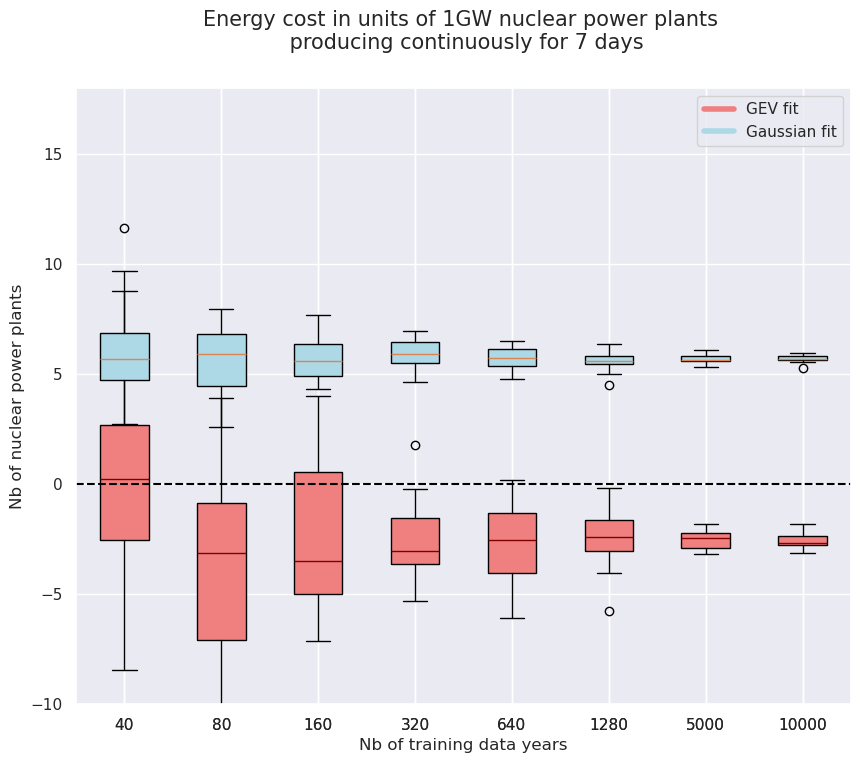

In [65]:
import seaborn as sns
sns.set()
# Create the box plot
fig, ax = plt.subplots(figsize=(10, 8))

bias = (-target_return_value + Xr_samples_list).T
# change color of median 
plt.boxplot(energy_cost, vert=True, patch_artist=True, labels=n_train_list, boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="maroon")) #, label= 'Gaussian fit')

bias_gauss = (-target_return_value + Xr_samples_list_gauss).T
# change color for the gaussian model
plt.boxplot(energy_cost_gauss, vert=True, patch_artist=True, labels=n_train_list, boxprops=dict(facecolor="lightblue")) #, label= 'Gaussian fit')

# Create custom handles for the legend
handles = [
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='GEV fit'),
    plt.Line2D([0], [0], color='lightblue', lw=4, label='Gaussian fit')
]


# Add the legend
plt.legend(handles=handles, loc='upper right')

# Add title and labels
plt.title('Box plot of n_values')
plt.xlabel('Nb of training data years')
plt.ylabel(f'Nb of nuclear power plants')
plt.title(f"Energy cost in units of 1GW nuclear power plants \n producing continuously for {T} days", y = 1.05, fontsize=15)
# plot a straight line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-10, 18)

# Show the plot
# # put a minus in the y-axis values but keep the same direction
# ax.set_yticklabels([f"{-y if y !=0 else 0}" for y in ax.get_yticks()])
plt.show()

## Third plot: Boxplots of biais v.s duration T of the event

In [71]:
T_list = [1, 3, 7, 14, 21]
n_mc = 4
n_train = 80

target_return_period = 1000 # We should probably stick to 1000 years to compare our plots (but feel free to try other values for your own curiosity)
bounds = dict(c=[-5, 5], loc=[-5, 15], scale=[0.001, 10])

target_return_value = get_target_return_value(X_test, target_return_period)[0]

Xr_samples_list = []
Xr_samples_list_gauss = []



for T in tqdm(T_list):

    A_train_val = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_train_val_T{7}.csv', index_col=0)
    A_test = pd.read_csv(f'/glade/work/alancelin/EVT_rossbypalooza/scripts/coldspells/data/A_test_T{7}.csv', index_col=0)
    X_train = - A_train_val.values.squeeze()
    X_test = - A_test.values.squeeze()


    Xr_samples = compute_MC_return_value(X_test, model_class, bounds, n_train=n_train, n_mc=n_mc, return_periods=target_return_period)
    Xr_samples_list.append(Xr_samples)
    Xr_samples_gauss = compute_MC_return_value(X_test, scipy.stats.norm , bounds=None, n_train=n_train, n_mc=n_mc, return_periods=target_return_period)
    Xr_samples_list_gauss.append(Xr_samples_gauss)
    
Xr_samples_list = np.stack(Xr_samples_list, axis=0)
Xr_samples_list_gauss = np.stack(Xr_samples_list_gauss, axis=0)

100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


/glade/derecho/scratch/alancelin/tmp/ipykernel_83378/3284955459.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{-y if y !=0 else 0}" for y in ax.get_yticks()])


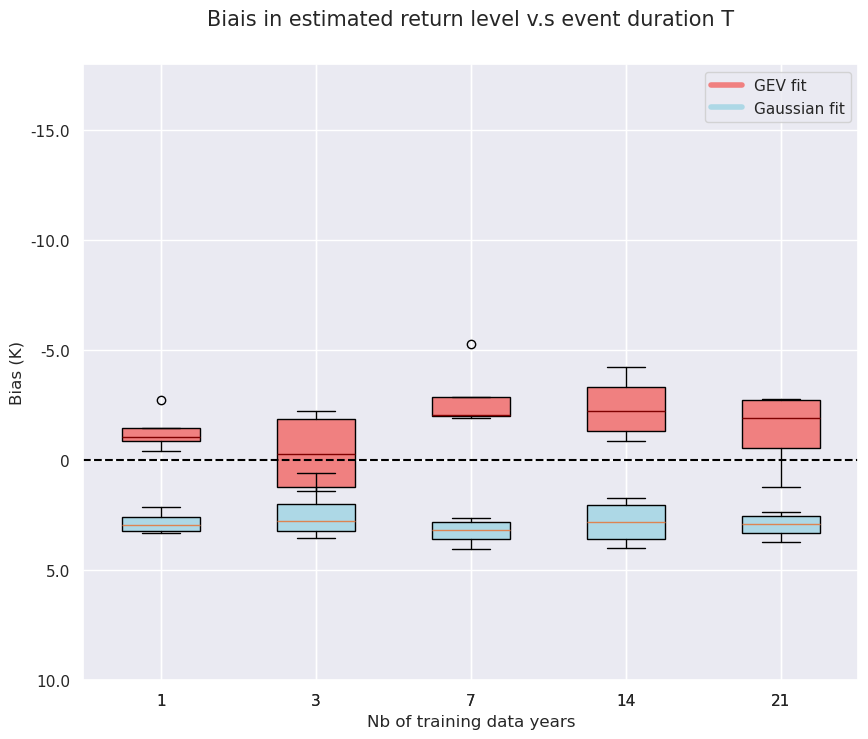

In [73]:
import seaborn as sns
sns.set()

# Create the box plot
fig, ax = plt.subplots(figsize=(10, 8))

bias = (-target_return_value + Xr_samples_list).T

# change color of median
plt.boxplot(bias, vert=True, patch_artist=True, labels=T_list, boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="maroon")) #, label= 'Gaussian fit')

bias_gauss = (-target_return_value + Xr_samples_list_gauss).T
# change color for the gaussian model
plt.boxplot(bias_gauss, vert=True, patch_artist=True, labels=T_list, boxprops=dict(facecolor="lightblue")) #, label= 'Gaussian fit')

# Create custom handles for the legend
handles = [
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='GEV fit'),
    plt.Line2D([0], [0], color='lightblue', lw=4, label='Gaussian fit')
]


# Add the legend
plt.legend(handles=handles, loc='upper right')

# Add title and labels
plt.title('Box plot of n_values')
plt.xlabel('Nb of training data years')
plt.ylabel(f'Bias (K)')
plt.title(f'Biais in estimated return level v.s event duration T', y = 1.05, fontsize=15)

# plot a straight line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-10, 18)

# Show the plot
# put a minus in the y-axis values but keep the same direction
ax.set_yticklabels([f"{-y if y !=0 else 0}" for y in ax.get_yticks()])
plt.show()

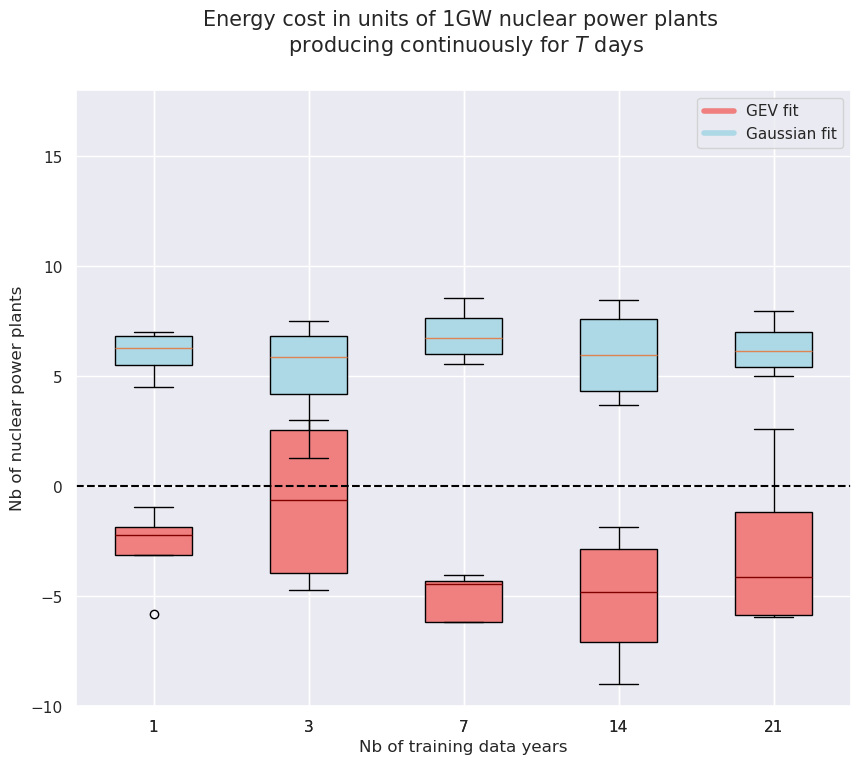

In [79]:
energy_cost = convert_to_Nuclear_power_plant_unit(bias, T=T)
energy_cost_gauss = convert_to_Nuclear_power_plant_unit(bias_gauss, T=T)

import seaborn as sns
sns.set()
# Create the box plot
fig, ax = plt.subplots(figsize=(10, 8))

bias = (-target_return_value + Xr_samples_list).T
# change color of median
plt.boxplot(energy_cost, vert=True, patch_artist=True, labels=T_list, boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="maroon")) #, label= 'Gaussian fit')

bias_gauss = (-target_return_value + Xr_samples_list_gauss).T
# change color for the gaussian model
plt.boxplot(energy_cost_gauss, vert=True, patch_artist=True, labels=T_list, boxprops=dict(facecolor="lightblue")) #, label= 'Gaussian fit')

# Create custom handles for the legend
handles = [
    plt.Line2D([0], [0], color='lightcoral', lw=4, label='GEV fit'),
    plt.Line2D([0], [0], color='lightblue', lw=4, label='Gaussian fit')
]

# Add the legend
plt.legend(handles=handles, loc='upper right')

# Add title and labels
plt.title('Box plot of n_values')
plt.xlabel('Nb of training data years')
plt.ylabel(f'Nb of nuclear power plants')

plt.title(f"Energy cost in units of 1GW nuclear power plants \n producing continuously for" +r" $T$ days", y = 1.05, fontsize=15)

# plot a straight line at 0
plt.axhline(y=0, color='black', linestyle='--')
plt.ylim(-10, 18)

# Show the plot
plt.show()